In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import pandas as pd

from utils.basic_utils import read_dates, load_csvs, csv_load
from utils.pricing import *
from utils.fundamental import filter_cols
from scipy.stats import linregress

import matplotlib as mpl
import matplotlib.pyplot as plt

# pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('precision', 3)

Loading utils/config.json


In [2]:
# utility functions
def top_recomm_by_class(pred_df, labels, top_items):
    mask = pred_df.hard_pred_label == pred_df.soft_pred_label
    agree_df = pred_df.loc[mask].drop_duplicates()
    # should add sector and industries, group for allocation insights
    # should add marketcap, beta, etc, group for risk exposure insights
    label_mask = agree_df.soft_pred_label.isin(['bear', 'short', 'long', 'bull'])
    return agree_df.loc[label_mask]\
        .sort_values(by='soft_confidence', ascending=False)\
        .groupby(by='soft_pred_label').head(top_items)\
        .sort_values(by='soft_pred_class')

def pred_distrib(pred_df, count_col):
    dist = pd.value_counts(pred_df[count_col]).to_frame()
    dist['weights'] = dist / dist.sum()
    return dist

def add_desc_stats(df, descriptive_cols):
    
    tickers = df.index
    for k in descriptive_cols.keys():
        desc_df, cols = descriptive_cols[k]['df'], descriptive_cols[k]['columns']
        for c in cols: df.loc[:, c] = tickers.map(desc_df[c].to_dict()).values 

    df = clean_df(df, large_vals, div_cols)

    df.loc[:, 'pegRatio'] = df.forwardPE / (val_df.growthRate * 100)
    df.loc[:, 'size'] = discret_rets(df.marketCap, mkt_cap_cuts, mkt_cap_labels)
        
    return df

def clean_df(df, large_vals, div_cols):
    # convert large values to billions
    df.loc[:, large_vals] = df.loc[:, large_vals] / 10**9
    df.loc[:, div_cols] = df[div_cols].div(df.regularMarketPrice, axis=0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

def ml_votes_by_class(fndm_dfs, group_mask):
    super_list = []
    for key in fndm_dfs.keys():
        df = fndm_dfs[key]
        super_list.append(
            fndm_dfs[key].loc[:, group_mask].set_index(re_index_col)\
            .rename(columns={group_mask[0]: key}))
    df = pd.concat(super_list, axis=1, sort=False)
    # df.apply(pd.value_counts).loc[fwd_ret_labels].style.background_gradient(cmap='RdYlGn')
    return df.T.apply(pd.value_counts).T

q_group = lambda x, q: x.quantile(q)

ticker_across_mls = lambda ticker, df: df.set_index('symbol').loc[ticker]

# equal weight ml_confidence
equal_wgt_conf = lambda x: ticker_across_mls(x[0]).loc[:, x[1]].mean()

# take index and class, and calculate a dot product, weighted confidence
score_wgt_conf = lambda x: ticker_across_mls(x[0], lf_df).loc[
    :, [x[1], 'model']].set_index('model').T.mul(model_weights).sum(1).iloc[0]

def load_s3_preds(s3_path, tgt_date, key_list, eqty_symbols, verbose=True):
    """ Read ML prediction files """
    print(f'Loading files for {tgt_date}')
    fndm_dfs = {k: pd.read_csv(csv_load(f'{s3_path[k]}{tgt_date}'), 
            index_col='pred_date', parse_dates=True) for k in key_list}

    super_list = []
    for key in fndm_dfs.keys(): 
        fndm_dfs[key].loc[:, 'model'] = key
        fndm_dfs[key] = fndm_dfs[key].loc[fndm_dfs[key].symbol.isin(eqty_symbols), :]
        df = fndm_dfs[key]
        if verbose: print(f'{key.upper()}, {df.symbol.shape[0]} unique symbols')
        super_list.append(df)
        
    return pd.concat(super_list, axis=0)

def get_wtd_ML_results(lf_df, model_weights):
    """ calculate model weighted class and confidence level for ranking / sorting """
    spc_df = lf_df.pivot_table(
        index=['symbol'], columns=['model'], 
        values=['soft_pred_class'], aggfunc='mean')\
        ['soft_pred_class'][list(model_weights.index)]
    wgt_class_df = (spc_df * model_weights.T).sum(axis=1)
    sc_df = lf_df.loc[:, ['symbol', 'soft_confidence', 'model']]\
        .pivot(index='symbol', columns='model', values='soft_confidence')\
                   .loc[:, model_weights.index]
    wgt_conf_df = (sc_df * model_weights.T).sum(axis=1)
    wtg_df = pd.concat([wgt_class_df, wgt_conf_df], axis=1, sort=False)
    wtg_df.columns = ['wtg_class', 'wtg_ML_prob']
    wtg_df[lf_df.index.name] = lf_df.index.unique()[0]
    
    return wtg_df

def visualize_MLs(lf_df, key_list):
    pvt_df = lf_df.pivot_table(
        index=['model'], columns=['soft_pred_label'], 
        values=['soft_confidence'], aggfunc='count')
    class_distrib = pvt_df.div(pvt_df.sum(axis=1), axis=0)['soft_confidence'][fwd_ret_labels]
    # plot mean class across models    
    class_distrib.mean(axis=0).plot.barh(title='Mean prediction by class',);
    plt.savefig('../images/ML_mean_weight.png', dpi=300, rot=0, bbox_inches='tight')
    # plot class distribution by model    
    class_distrib.plot(title='Prediction distribution by model', kind='barh', stacked=True, cmap='RdYlGn');
    plt.savefig('../images/ML_class_distrib.png', dpi=300, rot=0, bbox_inches='tight')
    return class_distrib.T[key_list]

conf_slope = lambda y: linregress(range(len(y)), y).slope

In [3]:
# s3 paths
s3_path = {
    'macro': 'recommend/macro_ML/',
    'px_mom': 'recommend/micro_ML/',
    'fin_data': 'recommend/fdmn_ML-fin_data/',
    'key_statistics': 'recommend/fdmn_ML-key_statistics/',
    'eps_trend': 'recommend/fdmn_ML-eps_trend/',
    'eps_estimates': 'recommend/fdmn_ML-eps_estimates/',
    'day_quote': 'recommend/fdmn_ML-day_quote/',
    'iv_value': 'valuation/waterfall/'
}

In [4]:
# environment variables
bench = '^GSPC'
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
show_classes = ['bear', 'short', 'long', 'bull']
min_confidence = 0.5
max_rows = 20
roll_pred_days = 8

key = 'fin_data'
agg_funcs = ['count', 'median', 'max']
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

re_index_col = 'symbol'
value_col = 'soft_confidence'
show = ['symbol', 'soft_confidence']
mask_col, class_value = 'soft_pred_label', 'bull'
hard_vote, soft_vote = 'hard_pred_label', 'soft_pred_label'

large_vals = ['marketCap']
div_cols = ['targetMeanPrice', 'targetMedianPrice']

In [5]:
# context / descriptive data
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3

quotes = load_csvs('quote_consol', [tgt_date])

dollar_vol = ((quotes.averageDailyVolume10Day * quotes.regularMarketPrice) / 10**6)
quotes.loc[(dollar_vol > dollar_vol.quantile(0.2)) & (quotes['quoteType'] == 'EQUITY')] # the delta
mask = (dollar_vol > dollar_vol.quantile(0.1)) & (quotes['quoteType'] == 'EQUITY') & (quotes['regularMarketPrice'] > 5)
eqty_symbols = excl(quotes.loc[mask].symbol, ['GOOGL'])
# quotes.loc[quotes['quoteType'] == 'EQUITY'].index.difference(eqty_symbols) # the delta

profile = load_csvs('summary_detail', ['assetProfile'])
keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date)])
finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date)])

for df in (quotes, profile, keystats, finstats):
    df.set_index('symbol', drop=False, inplace=True)
    
path = 'valuation/waterfall/'
print(f'Loading file {path}{tgt_date}')
val_df = pd.read_csv(csv_load(path+tgt_date), parse_dates=True)
val_df.set_index('symbol', inplace=True)
val_df.dropna(subset=['premDisc'], inplace=True)
val_df = val_df.loc[(np.abs(val_df.premDisc) < val_df.premDisc.median() * 3).values, :]

descriptive_cols = {
    'quotes': { 'df': quotes, 'columns': ['shortName', 'forwardPE', 'trailingPE', 'marketCap', 'regularMarketPrice'],},
    'profile': { 'df': profile, 'columns': ['sector', 'industry', 'country'],},
    'keystats': { 'df': keystats, 'columns': ['pegRatio', 'shortPercentOfFloat'],},
    'finstats': { 'df': finstats, 'columns': ['earningsGrowth', 'recommendationMean', 'targetMeanPrice', 'targetMedianPrice', 'numberOfAnalystOpinions'],},
    'valuation': { 'df': val_df, 'columns': ['premDisc', 'growthRate'],},
}

Loading file quote/csv/2019-04-19
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-04-19
Loading file summary-categories/financialData/2019-04-19
Loading file valuation/waterfall/2019-04-19


In [7]:
!scp -i ~vveiga/.ssh/qc_infra.pem ubuntu@54.191.249.196:/home/ubuntu/inception/tmp/universe-px-ds ../tmp/universe-px-ds
px_close = load_px_close('../tmp/', 'universe-px-ds', True).drop_duplicates().dropna(subset=['^GSPC'])
px_close.info()

universe-px-ds                                100%   18MB   2.2MB/s   00:08    
<class 'pandas.core.frame.DataFrame'>
Index: 3776 entries, 2004-04-20 to 2019-04-18
Columns: 1308 entries, 0700.HK to KRW=X
dtypes: float32(1308)
memory usage: 18.9+ MB


### Macro / risk-exposure ML

In [8]:
# Read macro predictions
key = 'macro'
# show = ['hard_pred_label','soft_pred_label','soft_confidence','bear','short','neutral','long','bull']
macro_df = pd.read_csv(csv_load(f'{s3_path[key]}{tgt_date}'), index_col='pred_date', parse_dates=True)
macro_df.loc[:, :].tail()

,^GSPC,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,,,
2019-04-12,2907.41,3,long,3,long,0.757,2.765e-06,0.020,0.209,0.757,0.013
2019-04-15,2905.58,3,long,3,long,0.748,1.089e-05,0.020,0.225,0.748,0.007
2019-04-16,2907.06,3,long,3,long,0.765,6.444e-06,0.020,0.201,0.765,0.013
2019-04-17,2900.45,3,long,3,long,0.765,5.121e-06,0.027,0.194,0.765,0.014
2019-04-18,2905.03,3,long,3,long,0.742,1.131e-05,0.027,0.218,0.742,0.014


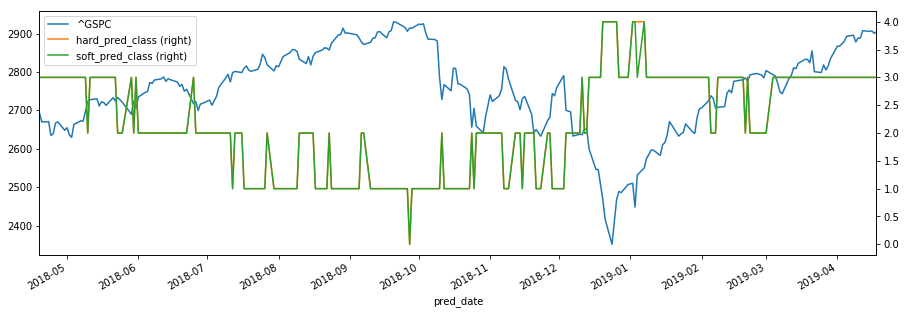

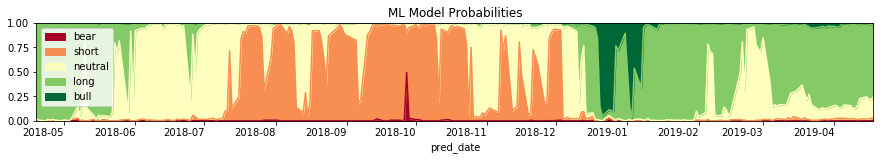

In [9]:
# Visualize macro predictions
pred_df = macro_df
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, 
    figsize=(15, 5));
plt.savefig('../images/macro_chart.png', dpi=300, rot=0)
pred_df[fwd_ret_labels].plot.area(
        title='ML Model Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0);
f'Confidence Mean: {pred_df["soft_confidence"].mean().round(3)}, \
    Median {pred_df["soft_confidence"].median().round(3)}'
plt.savefig('../images/macro_prob.png', dpi=300)

### Bottom-up MLs

In [10]:
tgt_date

'2019-04-19'

In [11]:
# 
key_list = ['px_mom', 'fin_data', 'key_statistics', 'eps_trend', 'eps_estimates', 'day_quote']
lf_df = load_s3_preds(s3_path, tgt_date, key_list, eqty_symbols)

# Model score weights 
ml_score_dict = {
    'px_mom': 0.76, 'fin_data': 0.67, 'key_statistics': 0.71, 
    'eps_trend': 0.65, 'eps_estimates': 0.64, 'day_quote': 0.66, 
    'intrinsic_val': 0.7
}
cut_off_confidence = 0.6
model_scores = np.array(list(map(ml_score_dict.get, list(key_list))))
adj_weights = (model_scores - cut_off_confidence) / (model_scores - cut_off_confidence).sum()
model_weights = pd.Series({x:y for x,y in zip(list(key_list), adj_weights)})
model_weights

Loading files for 2019-04-19
PX_MOM, 1066 unique symbols
FIN_DATA, 1043 unique symbols
KEY_STATISTICS, 1066 unique symbols
EPS_TREND, 1091 unique symbols
EPS_ESTIMATES, 1091 unique symbols
DAY_QUOTE, 1105 unique symbols


px_mom            0.327
fin_data          0.143
key_statistics    0.224
eps_trend         0.102
eps_estimates     0.082
day_quote         0.122
dtype: float64

model,px_mom,fin_data,key_statistics,eps_trend,eps_estimates,day_quote
soft_pred_label,,,,,,
bear,0.093,0.025,0.017,0.082,0.086,0.052
short,0.128,0.201,0.191,0.479,0.430,0.171
neutral,0.032,0.294,0.244,0.126,0.131,0.174
long,0.328,0.441,0.511,0.230,0.263,0.553
bull,0.419,0.038,0.037,0.082,0.090,0.051


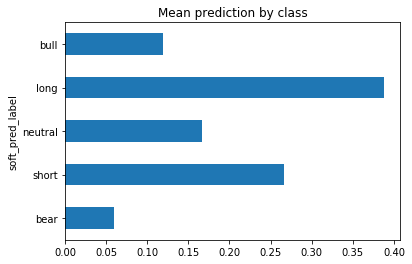

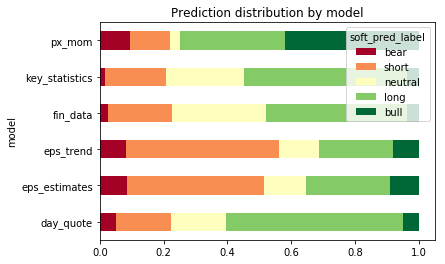

In [12]:
visualize_MLs(lf_df, key_list)

### Recomendations

#### Rolling [8] days recommendation

In [26]:
# retrieve historical recommendations for the last 5 days
super_list = []
for d in dates[:-roll_pred_days:-1]:
    lf_df = load_s3_preds(s3_path, d, key_list, eqty_symbols, verbose=False)
    wtg_df = get_wtd_ML_results(lf_df, model_weights)
    super_list.append(wtg_df)
hist_pred_df = pd.concat(super_list, axis=0)

print(f'Columns: {hist_pred_df.reset_index().columns}')
val_cols = ['wtg_class', 'wtg_ML_prob']
# remove duplicates required, given predictions on holidays
pvt_df = hist_pred_df.reset_index().drop_duplicates(subset=['symbol', 'pred_date'])\
    .pivot(index='symbol', columns='pred_date', values=val_cols)
# pvt_df = pvt_df.loc[(pvt_df.loc[pvt_df.index, 'wtg_ML_prob'] > min_confidence).all(axis=1), :]

hist_pred = pd.concat([
    pvt_df[val_cols[0]].mean(axis=1), 
    pvt_df[val_cols[1]].mean(axis=1)], axis=1)
hist_pred.columns = val_cols

Loading files for 2019-04-19
Loading files for 2019-04-18
Loading files for 2019-04-17
Loading files for 2019-04-16
Loading files for 2019-04-15
Loading files for 2019-04-12
Loading files for 2019-04-11
Columns: Index(['symbol', 'wtg_class', 'wtg_ML_prob', 'pred_date'], dtype='object')


In [29]:
show = ['wtg_class', 'wtg_ML_prob', 'conf_slope', 'forwardPE', 'shortName', 'sector', 'targetMedianPrice', 'size']

# best longs
L_df = hist_pred.loc[(hist_pred['wtg_class'] > 3) & (hist_pred['wtg_ML_prob'] > min_confidence), :]\
    .sort_values('wtg_ML_prob', ascending=False).head(max_rows)

L_df.loc[:, 'conf_slope'] = pvt_df.loc[L_df.index, 'wtg_ML_prob'].T.apply(conf_slope)
L_df = add_desc_stats(L_df, descriptive_cols)

# best shorts
S_df = hist_pred.loc[(hist_pred['wtg_class'] < 1) & (hist_pred['wtg_ML_prob'] > min_confidence), :]\
    .sort_values('wtg_ML_prob', ascending=False).head(max_rows)

S_df.loc[:, 'conf_slope'] = pvt_df.loc[S_df.index, 'wtg_ML_prob'].T.apply(conf_slope)
S_df = add_desc_stats(S_df, descriptive_cols)

In [32]:
L_df[show].sort_values(by=['wtg_ML_prob'], ascending=False)

,wtg_class,wtg_ML_prob,conf_slope,forwardPE,shortName,sector,targetMedianPrice,size
symbol,,,,,,,,
VIPS,3.190,0.647,0.032,10.167,Vipshop Holdings Limited,Consumer Cyclical,0.883,mid
FR,3.085,0.603,-0.003,44.190,"First Industrial Realty Trust,",Real Estate,1.046,mid
JD,3.075,0.591,0.009,32.269,"JD.com, Inc.",Consumer Cyclical,0.992,large
MSFT,3.054,0.580,0.014,24.674,Microsoft Corporation,Technology,1.054,mega
SBUX,3.163,0.578,0.001,25.102,Starbucks Corporation,Consumer Cyclical,0.920,large
VRSK,3.020,0.577,-0.005,28.047,"Verisk Analytics, Inc.",Industrials,0.957,large
HLT,3.150,0.575,0.018,20.333,Hilton Worldwide Holdings Inc.,Consumer Cyclical,1.055,large
BAX,3.218,0.566,0.002,19.928,Baxter International Inc.,Healthcare,1.096,large
STE,3.163,0.545,0.006,23.219,STERIS plc (Ireland),Healthcare,1.099,large


In [35]:
S_df[show].sort_values(by='conf_slope', ascending=False)

,wtg_class,wtg_ML_prob,conf_slope,forwardPE,shortName,sector,targetMedianPrice,size
symbol,,,,,,,,
ELY,0.68,0.515,0.001,14.765,Callaway Golf Company,Consumer Cyclical,1.355,small


In [49]:
# calculate # of shares
position_value = 50000
(position_value / quotes.loc[L_df.index, 'regularMarketPrice']).round(0)

symbol
BHP       910.0
VIPS     6305.0
JD       1666.0
TAL      1467.0
IDXX      229.0
SBAC      252.0
FR       1432.0
HLT       573.0
HALO     3131.0
SBUX      657.0
NSRGY     528.0
STE       407.0
BAX       673.0
EDU       556.0
MTD        69.0
PYPL      466.0
TMO       192.0
WAT       209.0
BDX       219.0
CHKP      417.0
Name: regularMarketPrice, dtype: float64

#### Daily recommendations

In [37]:
lf_df = load_s3_preds(s3_path, tgt_date, key_list, eqty_symbols)
wtg_df = get_wtd_ML_results(lf_df, model_weights)
wtg_df = add_desc_stats(wtg_df, descriptive_cols)

Loading files for 2019-04-19
PX_MOM, 1066 unique symbols
FIN_DATA, 1043 unique symbols
KEY_STATISTICS, 1066 unique symbols
EPS_TREND, 1091 unique symbols
EPS_ESTIMATES, 1091 unique symbols
DAY_QUOTE, 1105 unique symbols


In [38]:
# todays long positions
show = ['wtg_class','wtg_ML_prob','forwardPE', 'industry', 'targetMedianPrice', 'size']
L_df = wtg_df.loc[wtg_df['wtg_class'] > 3].sort_values(by='wtg_ML_prob', ascending=False).head(max_rows)
print(f'Long recommendations for {tgt_date}')
L_df.index

Long recommendations for 2019-04-19


Index(['BHP', 'VIPS', 'JD', 'TAL', 'IDXX', 'SBAC', 'FR', 'HLT', 'HALO', 'SBUX',
       'NSRGY', 'STE', 'BAX', 'EDU', 'MTD', 'PYPL', 'TMO', 'WAT', 'BDX',
       'CHKP'],
      dtype='object', name='symbol')

In [39]:
# todays short positions
S_df = wtg_df.loc[wtg_df['wtg_class'] < 1].sort_values(by='wtg_ML_prob', ascending=False).head(max_rows)
print(f'Short recommendations for {tgt_date}')
S_df.index

Short recommendations for 2019-04-19


Index(['PENN', 'SFM', 'ELY', 'ADNT', 'INGR', 'FNB', 'ZION', 'CMA', 'WDFC',
       'LULU', 'PLT', 'ETSY', 'ATGE', 'GS', 'WHR', 'ESV', 'KR', 'CATY', 'WWD',
       'CBT'],
      dtype='object', name='symbol')

#### Company details

In [46]:
# Company view across models
ticker = 'BMY'
show = [
    'hard_pred_label','soft_pred_label','soft_confidence',
    'bear', 'short', 'neutral', 'long', 'bull', 'model' ,'sector']
wgt_input = (ticker, 'soft_confidence')
print(f'Model predictions for {ticker} on {tgt_date}')
print(f'Weighted ML confidence level: {score_wgt_conf(wgt_input)}')
lf_df.loc[lf_df['symbol'] == ticker, show]

Model predictions for BMY on 2019-04-19
Weighted ML confidence level: 0.36947643186137613


,hard_pred_label,soft_pred_label,soft_confidence,bear,short,neutral,long,bull,model,sector
pred_date,,,,,,,,,,
2019-04-18,bull,bull,0.324,0.197,0.150,0.210,0.120,0.324,px_mom,NaN
2019-04-19,long,long,0.359,0.032,0.296,0.181,0.359,0.132,fin_data,NaN
2019-04-19,long,long,0.412,0.048,0.289,0.210,0.412,0.041,key_statistics,NaN
2019-04-19,short,short,0.374,0.125,0.374,0.143,0.265,0.092,eps_trend,NaN
2019-04-19,short,short,0.473,0.072,0.473,0.134,0.256,0.066,eps_estimates,NaN
2019-04-19,long,long,0.352,0.069,0.226,0.267,0.352,0.086,day_quote,NaN


In [ ]:
quotes.loc[ticker]

### Universe Intrinsic Value Analysis

In [43]:
# Value companies in the universe
iv_show = ['premDisc', 'forwardPE', 'targetMedianPrice', 'pegRatio', 'growthRate']
iv_sizes = ['mega', 'large', 'mid']

iv_mask = (val_df.premDisc < 0.95) & (val_df.premDisc > 0)
iv_mapper = val_df.loc[iv_mask, 'premDisc']
iv_df = add_desc_stats(iv_mapper.to_frame(), descriptive_cols)
iv_df = iv_df.loc[iv_df['size'].isin(iv_sizes) & (iv_df.targetMedianPrice > 1.1), :]

iv_df.groupby(by=['sector', ]).agg(['count', 'median'])\
    .sort_values(by=(iv_show[0], 'median'))[iv_show]

premDisc        forwardPE         targetMedianPrice  \
                          count median     count  median             count   
sector                                                                       
Financial Services           26  0.341        26   9.827                26   
Industrials                   9  0.528         9   8.079                 9   
Basic Materials               5  0.633         5   7.105                 5   
Communication Services        3  0.661         2   5.612                 3   
Technology                    6  0.692         6  15.393                 6   
Consumer Defensive            2  0.745         2  14.130                 2   
Consumer Cyclical            14  0.763        14  10.911                14   
Healthcare                    8  0.768         8   9.531                 8   
Energy                       10  0.779         9   9.821                10   
Utilities                     2  0.803         2   3.990                 2   

                                pegRatio        growthRate         
                         median    count median      count median  
sector                                                             
Financial Services        1.130       26  0.827         26  0.116  
Industrials               1.152        9  1.100          9  0.073  
Basic Materials           1.254        5  1.004          5  0.070  
Communication Services    1.176        2    inf          3  0.027  
Technology                1.166        6  0.711          6  0.220  
Consumer Defensive        1.117        2  1.377          2  0.109  
Consumer Cyclical         1.161       14  1.608         14  0.059  
Healthcare                1.382        8  0.494          8  0.233  
Energy                    1.226        9  1.504         10  0.070  
Utilities               381.896        2    inf          2  0.039

In [44]:
iv_df.loc[:, iv_show + ['sector', 'size']].sort_values(
    by=['size', 'premDisc', 'sector'], ascending=False).head(max_rows)

,premDisc,forwardPE,targetMedianPrice,pegRatio,growthRate,sector,size
symbol,,,,,,,
FB,0.770,20.122,1.122,0.455,0.442,Technology,mega
BMY,0.941,10.252,1.252,0.393,0.261,Healthcare,large
PANW,0.941,36.619,1.210,1.864,0.196,Technology,large
HUM,0.926,12.523,1.460,0.609,0.206,Healthcare,large
TOT,0.887,8.990,1.252,1.504,0.060,Energy,large
REPYY,0.880,NaN,2.216,NaN,0.000,Energy,large
MCK,0.871,8.058,1.183,inf,0.000,Healthcare,large
COP,0.863,14.677,1.184,inf,0.000,Energy,large
GILD,0.842,9.084,1.303,inf,0.000,Healthcare,large


### Visualizations

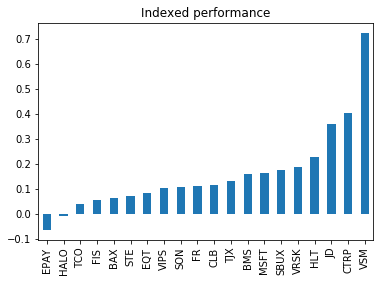

In [33]:
# 3 month indexed performance
(get_ind_index(px_close.loc[:, list(L_df.index)]).iloc[-1, :-1].sort_values() - 1).plot(
    title='Indexed performance', kind='bar');

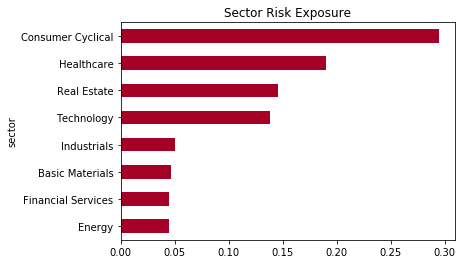

In [207]:
total_conf = pd.concat([L_df, S_df], axis=0, sort=False).wtg_ML_prob.sum()
long_sect_grps = L_df.groupby(by='sector').sum()['wtg_ML_prob'] / total_conf
if len(S_df): long_sect_grps.append((S_df.groupby(by='sector').sum()['wtg_ML_prob'] / total_conf) * -1)
long_sect_grps = long_sect_grps.sort_values()
long_sect_grps.plot.barh(title='Sector Risk Exposure', cmap="RdYlGn")

plt.savefig('../images/ls_sector_exp.png', dpi=300, rot=0, bbox_inches='tight')

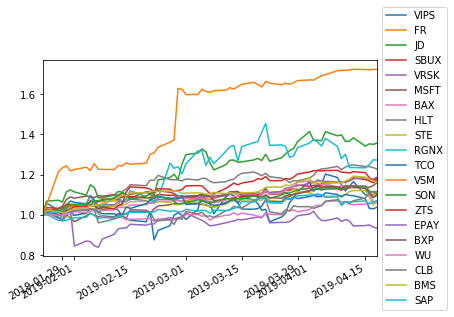

In [227]:
# backward looking performance of L/S recommendations
px_df_idx = get_ind_index(px_close.loc[:, list(L_df.index)])
px_df_idx.iloc[:, :-1].plot().legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

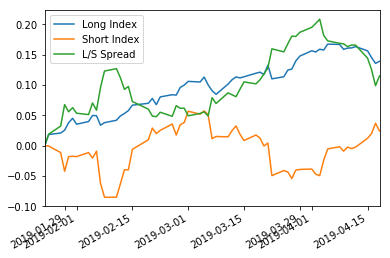

In [228]:
(L_df_idx.iloc[:, -1] - 1).plot(legend=True, label='Long Index')
if len(S_df_idx): 
    (S_df_idx.iloc[:, -1] - 1).plot(legend=True, label='Short Index')
    (L_df_idx.iloc[:, -1] - S_df_idx.iloc[:, -1]).plot(legend=True, label='L/S Spread');